In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
%load_ext autoreload
%autoreload 2

Import packages for NN

In [4]:
import numpy as np
import matplotlib.pyplot as plt 
import numpy.matlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy
import warnings
warnings.filterwarnings("ignore")

import scipy.stats as st 
from scipy.stats import norm

Set Plotting Styles

In [5]:
import seaborn as sns
sns.set_theme()

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%matplotlib inline

# 1. Introduction

In this project, I developed a deep learning approach for valuing options and determing the optimal hedging strategy when there are transaction costs. For example, when I trade there is a transaction cost of $0.005$ per asset traded (whether bought or sold). Assuming I have sold a bull call spread option, which pays $F(S_T)$ at $T$, where $F(S) = (S-K_1)_+ - (S-K_2)_+$ and $K_1=9.50, K_2=10.50$

In addition, I assume that I hedge my position on a daily basis over 90 trading days and I only consider investing in the bank account and the underlying asset.

# 2. Asset Price Paths

Suppose that the asset price $S=(S_t)_{t \geq 0}$ satisfies the following stochastic differential equation

\begin{equation}
dS_t = \kappa (\theta - \mbox{log}{S_t})S_t dt + \sigma S_t dW_t \nonumber
\end{equation}

where $W = (W_t)_{t \geq 0}$ is a $\mathbb{P}$-Brownian motion. For the base parameters, we assume that (all in annualized values)

\begin{equation}
S_0 = 10, \kappa = 2, \theta = \mbox{log } (10), \sigma = 40\%, r = 2\% \nonumber
\end{equation}

By Euler discretization, we have
\begin{equation} \label{eq:2}
dS_{t+\Delta} = \kappa (\theta - \mbox{log}{S_t})S_t (\Delta t) + \sigma S_t \sqrt{t} Z_t \nonumber
\end{equation}

where $Z_t \stackrel{i.i.d}{\sim} N(0,1)$.

In [6]:
# asset price simulation parameters
S0 = 10              # asset start price
kappa = 2            # drift parameter 1
theta = np.log(10)   # drift parameter 2
sigma = 0.4          # volatility
r = 0.02             # risk-free rate  

In [7]:
# option parameters
T = 0.25   # option mature in 0.25 year (i.e., 3 months)
NdT = 90   # 90 time steps for trading daily to hedge
e = 0.005  # transaction cost per asset traded
K1 = 9.50  # strike price for C1
K2 = 10.50 # strike price for C2

t = np.linspace(0,T,NdT)
dt = t[1]-t[0]    
sqrt_dt = np.sqrt(dt)

Simulate Asset Prices in Torch Environment

In [8]:
nsims = 12

In [9]:
S = torch.zeros((nsims, NdT))
log_S = torch.zeros((nsims, NdT))
S[:,0] = S0
log_S[:,0] = np.log(S0)

In [10]:
for i in range(NdT-1):
    log_S[:,i+1] = log_S[:,i]+(kappa*(theta - log_S[:,i]) - 0.5*sigma**2) * dt + sigma * sqrt_dt * torch.normal(0,1,size=(nsims,))

In [11]:
S = torch.exp(log_S)

Plot the Asset Price Paths

In [12]:
import plotly.graph_objects as go
fig = go.Figure()
for i in range(12):
    fig.add_trace(go.Scatter(x=t, y=S[i,:], name="path " + str(i+1)) )

fig.update_layout(
    title="Asset Simulation Paths",
    xaxis_title=r"$t$",
    yaxis_title=r"$S_t$",
    font=dict(
        size=18,
        color="RebeccaPurple") )

fig.show()

# 3. BS Hedging Strategies

Classical Black-Scholes hedge refers to the delta hedge strategy, which is discretime time hedging strategy by rebalancing the position of the underlying asset at equal spaced time steps.

In [13]:
def CallPrice(S,K,tau,sigma,r):
    dp = (np.log(S/K)+(r+0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    dm = (np.log(S/K)+(r-0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    
    return S*norm.cdf(dp) - K*np.exp(-r*tau)*norm.cdf(dm) 

In [14]:
def CallDelta(S,K,tau,sigma,r):
    # add a tiny amount of time for maturity, so won't raise an error
    tau+=1e-10
    dp = (np.log(S/K)+(r+0.5*sigma**2)*tau)/(np.sqrt(tau)*sigma)
    
    return norm.cdf(dp)

Bull Call Spread Option BS Prices

In [15]:
C1 = CallPrice(S0,K1,T,sigma,r)
C1

1.0788233040299895

In [16]:
C2 = CallPrice(S0,K2,T,sigma,r)
C2

0.6099437898191793

In [17]:
# bull call spread strategy Black-Scholes price
C1-C2

0.4688795142108102

Bull Call Spread Option initial Black-Scholes Delta, which is the amount of asset the trader needs to buy to hedge the short position of the bull call spread option.

In [18]:
delta_1 = CallDelta(S0,K1,T,sigma,r)
delta_2 = CallDelta(S0,K2,T,sigma,r)
delta_1 - delta_2

0.19591426814748392

In [19]:
def RunHedge_BS(S, alpha):
    
    '''
    S: a collection of simulations of asset prices
    each row is going to be one simulation
    each column is going to represent time step
    
    alpha: the position that to hold in the risky asset, i.e., delta of the bull spread option
    '''
    
    # start the bank account with value of contract and purchasing initial shares
    # assume initially charge nothing for the option
    # the output of the neural net will have an extra dimension to it
    bank = C1 - C2 - alpha[:,0,0]*S[:,0] - abs(alpha[:,0,0])*0.005
    
    for i in range(NdT-1):
        
        # accumulate bank account to next time step
        bank *= np.exp(r*dt)
        
        # rebalance the position and consider the transaction cost $0.005 per asset traded
        bank -= (alpha[:,i+1,0]-alpha[:,i,0]) * S[:,i+1] + abs(alpha[:,i+1,0]-alpha[:,i,0])*0.005
        
    # liquidate terminal assets, and pay what you owe from the contract
    # owe the payoff of C1, so minus
    # long the payoff of C2, so plus
    
    bank += alpha[:,-1,0]*S[:,-1] + (S[:,-1]-K2)*(S[:,-1]>K2) - (S[:,-1]-K1)*(S[:,-1]>K1)  
    
    return bank

In [20]:
def Sim_BS(nsims):
    
    # simulate asset price path
    S = torch.zeros((nsims, NdT))
    log_S = torch.zeros((nsims, NdT))
    S[:,0] = S0
    log_S[:,0] = np.log(S0)
    
    for i in range(NdT-1):
        log_S[:,i+1] = log_S[:,i]+(kappa*(theta - log_S[:,i]) - 0.5*sigma**2) * dt + sigma * sqrt_dt * torch.normal(0,1,size=(nsims,))
    
    S = torch.exp(log_S)
    #print('S',S)
    # position to hold is delta_1 - delta_2
    alpha_BS = torch.unsqueeze( torch.tensor(CallDelta(S.detach().numpy(), K1, T-np.matlib.repmat(t,nsims,1), sigma, r)
                                            -CallDelta(S.detach().numpy(), K2, T-np.matlib.repmat(t,nsims,1), sigma, r)), dim=2)
    
    #print('alpha_BS',alpha_BS)
    
    bank_BS = RunHedge_BS(S, alpha_BS)
    
    #print('bank_BS',bank_BS)
    
    return bank_BS

Run 5000 simulated scenarios to see the Black-Scholes hedging strategy's final PnL

In [21]:
PnL_BS = Sim_BS(5_000)

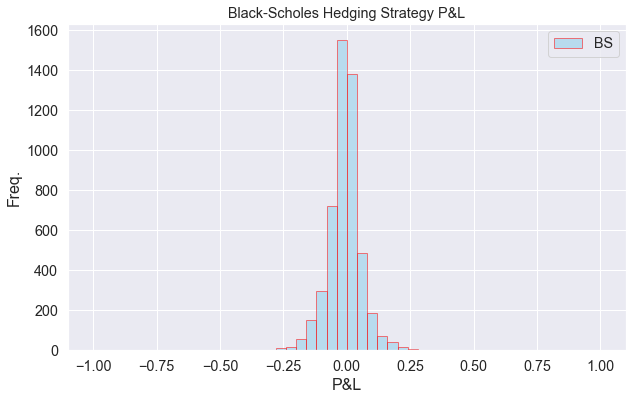

In [22]:
plt.figure(figsize=(10,6))
plt.hist(PnL_BS.detach().numpy(),bins=np.linspace(-1,1,51),color="skyblue", ec="red",alpha=0.5,label="BS");
plt.xlabel('P&L',fontsize=16)
plt.ylabel('Freq.',fontsize=16)
plt.title("Black-Scholes Hedging Strategy P&L")
plt.legend();

# 4. Feed Forward Neural Net Architecture

I first use feed forward neural network architecture to generate the hedging strategies. The input is two-dimensional, one is current time and current asset price. Then I Set the negative CVaR as the loss function, in order to find a neural net that could output a maximum CVaR value and I also need to make sure the CVaR at 10% significant level is no worse than $0.02.

In [23]:
class HedgeNet(nn.Module):
    
    def __init__(self, nNodes, nLayers ):
        
        # constructor of neural nets
        super(HedgeNet, self).__init__()
        
        # from input to 1st hidden layer
        self.prop_in_to_h = nn.Linear(2, nNodes)
        
        # generate hidden layer to hidden layer
        self.prop_h_to_h = []
        for i in range(nLayers-1):
            self.prop_h_to_h.append(nn.Linear(nNodes, nNodes))
        
        # from hidden layer to output
        self.prop_h_to_out = nn.Linear(nNodes, 1)

    def forward(self, x):
        
        # activiation function for input to hidden layer
        h = torch.sigmoid(self.prop_in_to_h(x))
        
        # activiation function for hidden to hidden layer
        for prop in self.prop_h_to_h:
            h = torch.relu(prop(h))
        
        # hidden layer to output layer - no activation(identify function)
        # output is a real number (i.e., -inf to inf)
        y = self.prop_h_to_out(h)
        
        return y
    
    # list of tunable parameters
    def parameters(self):
        
        params = list(self.prop_in_to_h.parameters())
        for prop in self.prop_h_to_h:
            params += list(prop.parameters())
            
        params += list(self.prop_h_to_out.parameters())
        
        return params

In [24]:
def RunHedge(S, alpha):
    '''
    S: a collection of simulations of asset prices
    each row is going to be one simulation
    each column is going to represent time
    
    alpha: the position that to hold in the risky asset
    '''
    
    # start the bank account with value of contract and purchasing initial shares
    # assume initially charge nothing for the option
    # the output of the neural net will have an extra dimension to it
    bank = - alpha[:,0,0]*S[:,0] - abs(alpha[:,0,0])*0.005
    
    for i in range(NdT-1):
        
        # accumulate bank account to next time step
        bank *= np.exp(r*dt)
        
        # rebalance the position and consider the transaction cost $0.005 per asset traded
        bank -= (alpha[:,i+1,0]-alpha[:,i,0]) * S[:,i+1] + abs(alpha[:,i+1,0]-alpha[:,i,0])*0.005
        
    # liquidate terminal assets, and pay what you owe from the contract
    # owe the payoff of C1, so minus
    # long the payoff of C2, so plus
    bank += alpha[:,-1,0]*S[:,-1] + (S[:,-1]-K2)*(S[:,-1]>K2) - (S[:,-1]-K1)*(S[:,-1]>K1)  
    
    return bank

In [25]:
def Sim(net, nsims):
    
    # simulate the asset price
    S = torch.zeros((nsims, NdT))
    log_S = torch.zeros((nsims, NdT))
    S[:,0] = S0
    log_S[:,0] = np.log(S0)
    
    for i in range(NdT-1):
        log_S[:,i+1] = log_S[:,i]+(kappa*(theta - log_S[:,i]) - 0.5*sigma**2) * dt + sigma * sqrt_dt * torch.normal(0,1,size=(nsims,))
    
    S = torch.exp(log_S)
    #print("S",S)
    
    # combine the features into a tensor of dimension nsims x ndt x 2 
    x = torch.zeros((nsims, NdT,2))
    # first feature is time
    x[:,:,0] = torch.tensor(2*t/T-1).float().repeat(nsims,1)
    # second feature is asset price
    x[:,:,1] = 2*S/S0-1
    #print("x",x)
    
    # push the x values through the ANN -- the last dimension is treated as the features
    alpha = net(x)
    
    #print("alpha",alpha)
    
    bank = RunHedge(S, alpha)
    
    #print("bank",bank)

    return bank

This is the base case scenario.

In [26]:
# try depth = 3, width = 50
net = HedgeNet(50,3)
print(net)
for param in net.parameters():
    print(type(param.data), param.size())

HedgeNet(
  (prop_in_to_h): Linear(in_features=2, out_features=50, bias=True)
  (prop_h_to_out): Linear(in_features=50, out_features=1, bias=True)
)
<class 'torch.Tensor'> torch.Size([50, 2])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([50, 50])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([50, 50])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([1, 50])
<class 'torch.Tensor'> torch.Size([1])


In [27]:
def Plot_Strategy(net):
    
    t = [0,0.5*T,0.9*T]
    S = np.linspace(0.75*K1,1.25*K1,51)
    plt.figure(figsize=(15,5))
    plt.suptitle("ANN Structure: Width=50, Depth=3", fontsize=16)
    for i, t_ in enumerate(t):
        
        plt.subplot(1,3,i+1)
        plt.title('t=' + str(t_),fontsize=16)
        
        plt.plot(S, CallDelta(S,K1, T-t_, sigma, r)-CallDelta(S,K2, T-t_, sigma, r),label="BS")
        
        x = torch.zeros((len(S),2))
        x[:,0] = 2*t_/T-1
        x[:,1] = torch.tensor(2*S/S0-1)
        
        alpha = net(x)
        
        plt.plot(S, alpha.detach().numpy(),'--',label="ANN")
        
        plt.xlabel('S', fontsize=16)
        plt.ylabel(r'$\Delta(S)$', fontsize=16)
        plt.legend(loc='upper left')
        #plt.ylim(-0.4,0.6)
        
    plt.tight_layout()
    plt.show()

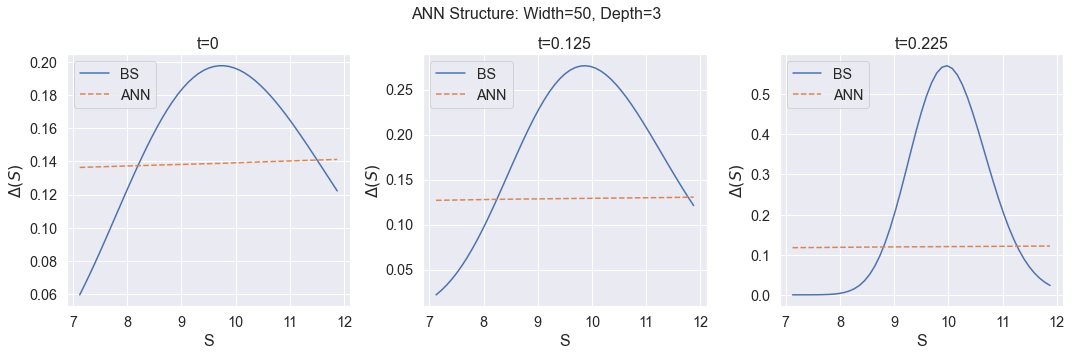

In [28]:
Plot_Strategy(net)

In [29]:
def Plot_PnL(loss_hist, net, name=""):
    plt.figure(figsize=(12,6))
    plt.suptitle("ANN Structure: Width=50, Depth=3", fontsize=16)
    plt.subplot(1,2,1)
    plt.plot(loss_hist)
    #plt.yscale('log')
    plt.xlabel('iteration',fontsize=16)
    plt.ylabel('loss',fontsize=16)
    #plt.ylim(1e-3,1)

    plt.subplot(1,2,2)
    PnL = Sim(net, 5_000)
    PnL_BS = Sim_BS(5_000)
    plt.hist(PnL_BS.detach().numpy(), bins=np.linspace(-1,1,51), alpha=0.6,color="skyblue", ec="brown",label="BS")
    plt.hist(PnL.detach().numpy(), bins=np.linspace(-1,1,51), alpha=0.6,color="orange",ec="black",label="ANN")    
    plt.xlabel('P&L',fontsize=16)
    plt.ylabel('Freq.',fontsize=16)
    #plt.ylim(0,1000)
    plt.legend()
    
    plt.tight_layout(pad=2)

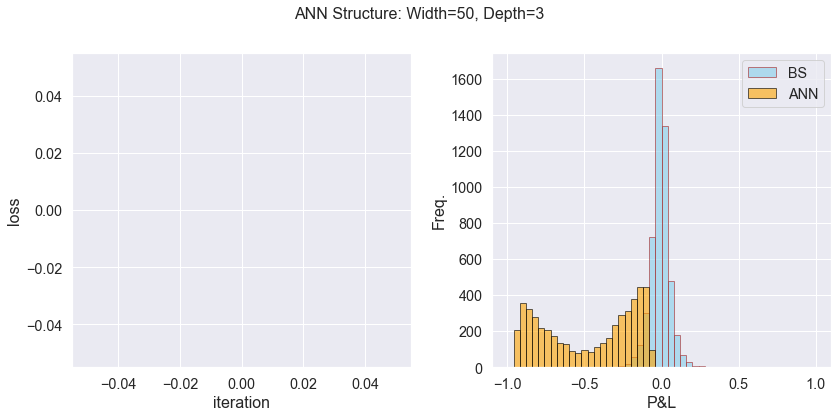

In [30]:
Plot_PnL([], net)

Illustration of VaR for the Normal Distribution in PyTorch

In [31]:
draws = torch.normal(0,1,size=(100000,1))
draws

tensor([[-0.8840],
        [-1.0154],
        [-1.4825],
        ...,
        [-2.3906],
        [ 1.1429],
        [-0.6453]])

In [32]:
q = torch.tensor([0.1])

In [33]:
VaR_10 = np.quantile(draws,q)
VaR_10.dtype

dtype('float64')

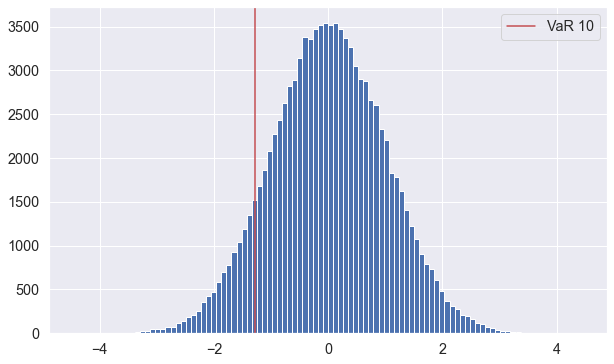

In [34]:
plt.figure(figsize=(10,6))
plt.hist(draws.detach().numpy(),bins=100)
plt.axvline(x=VaR_10,c='r',label="VaR 10")
plt.legend();

In [35]:
CVaR_10 = draws[draws.detach().numpy()<=VaR_10].mean()
CVaR_10.type()

'torch.FloatTensor'

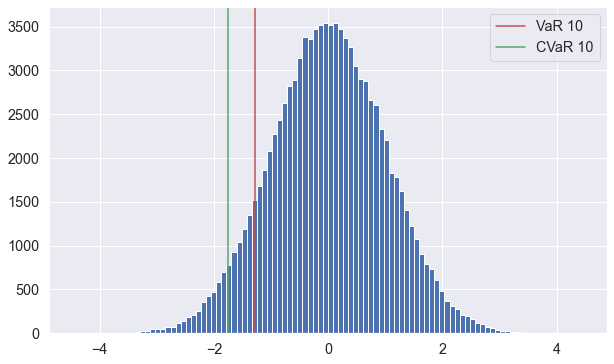

In [36]:
plt.figure(figsize=(10,6))
plt.hist(draws.detach().numpy(), bins = 100)
plt.axvline(x = VaR_10, c='r', label = "VaR 10")
plt.axvline(x = CVaR_10, c='g', label = "CVaR 10")
plt.legend(); 

With 5,000 epochs of training to check the process of selecting the optimal neural network.

In [37]:
def FitNet(net):
    
    mini_batch_size = 100
    
    # create  optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.005)

    Nepochs = 5_000
    loss_hist = []
    
    Plot_PnL(loss_hist, net)
    Plot_Strategy(net)
    
    for epoch in range(Nepochs):  # loop over the dataset multiple times

        # grab a mini-batch from simulations
        PnL = Sim(net, mini_batch_size)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # compute the loss associated with this output
        # CVaR_0.1 calculation
        q = torch.tensor([0.1])
        VaR_10 = np.quantile(PnL.detach().numpy(),q)
        CVaR_10 = PnL[PnL.detach().numpy()<=VaR_10].mean()
        loss = -CVaR_10

        # propogate the sensitivity of the output to the model parameters 
        # backwards through the computational graph
        loss.backward()

        # update the weights and biases by taking a SGD step
        optimizer.step()

        # store running loss
        loss_hist.append(  loss.item() )
        
        if( ( (epoch) % 500 == 0) and (epoch>10) ):
            print(epoch)
            Plot_PnL(loss_hist, net)
            Plot_Strategy(net)
    
    print(epoch)
    Plot_PnL(loss_hist, net)
    Plot_Strategy(net)
    print('Finished Training')

    return loss_hist

In [38]:
PnL = Sim(net, 5_000)
q = torch.tensor([0.1])
VaR_10 = np.quantile(PnL.detach().numpy(),q)
CVaR_10 = PnL[PnL.detach().numpy()<=VaR_10].mean()

In [39]:
CVaR_10

tensor(-0.9216, grad_fn=<MeanBackward0>)

In [40]:
plt.figure(figsize=(10,6))
plt.hist(PnL.detach().numpy(), bins = 100)
plt.axvline(x = VaR_10, c='r', label = "VaR 10")
plt.axvline(x = CVaR_10, c='g', label = "CVaR 10")
plt.legend(); 

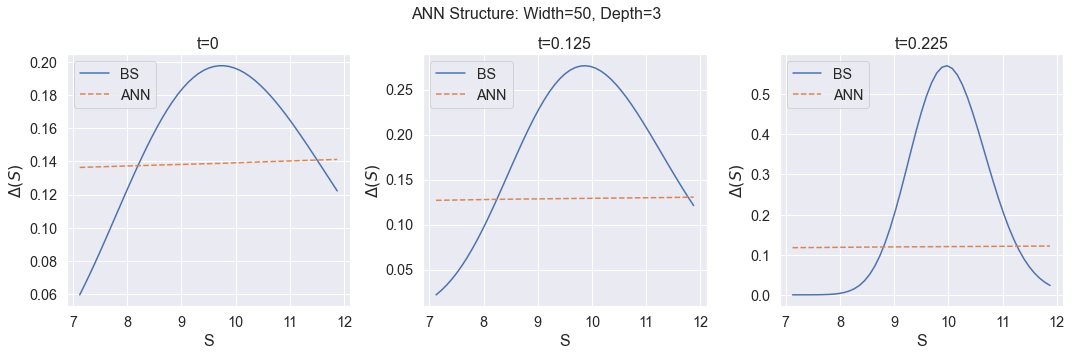

500


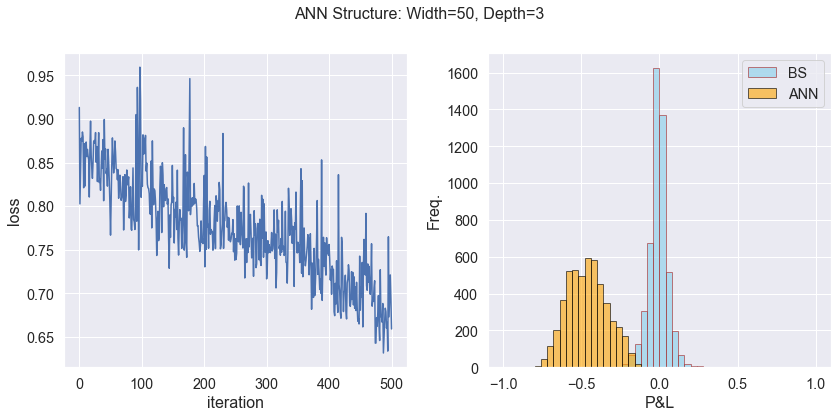

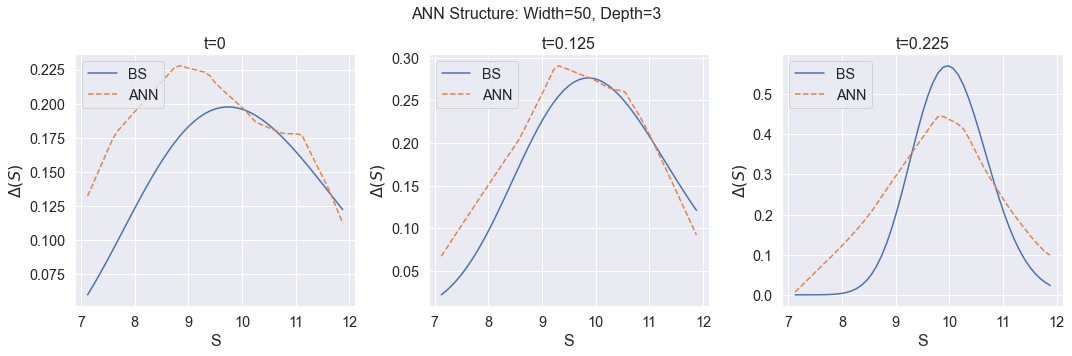

1000


1500


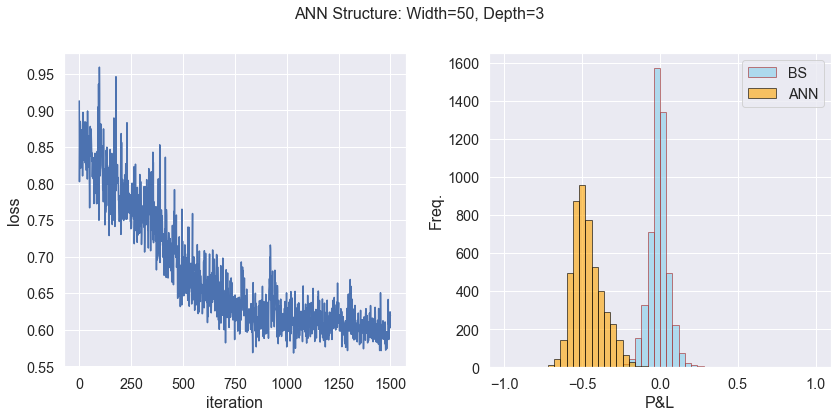

2000


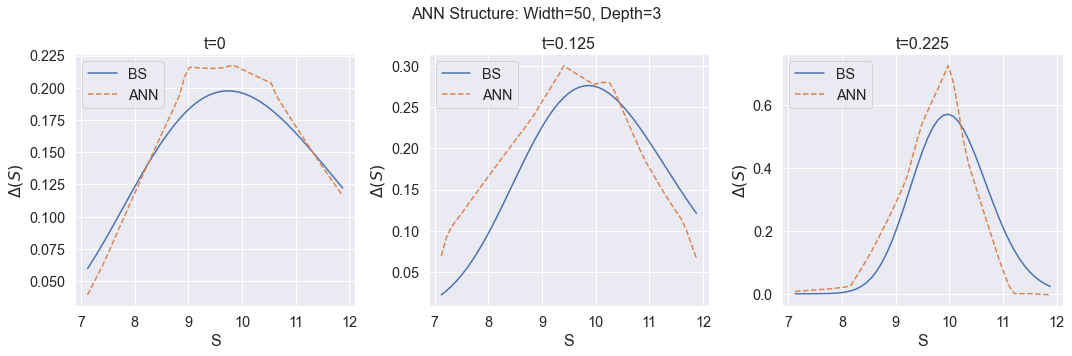

2500


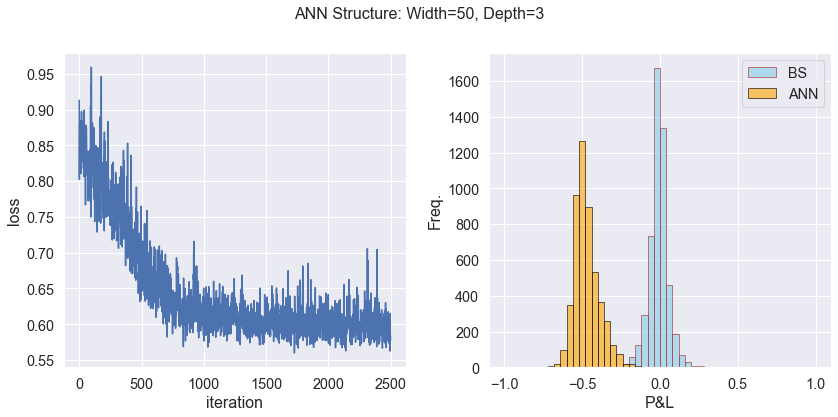

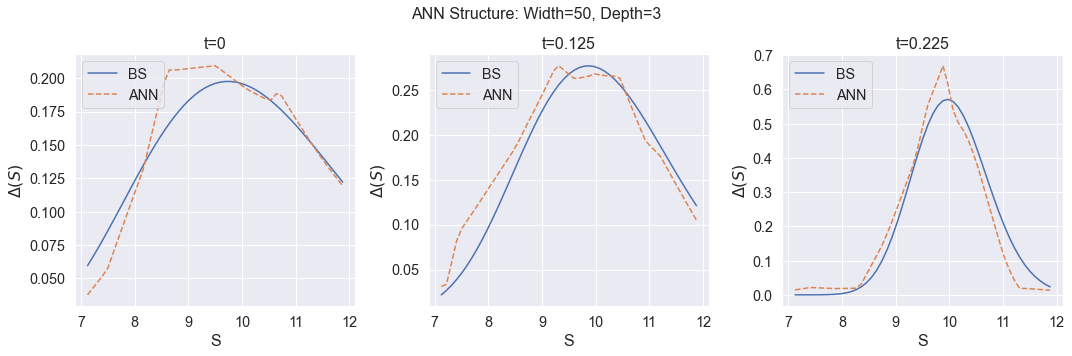

3000


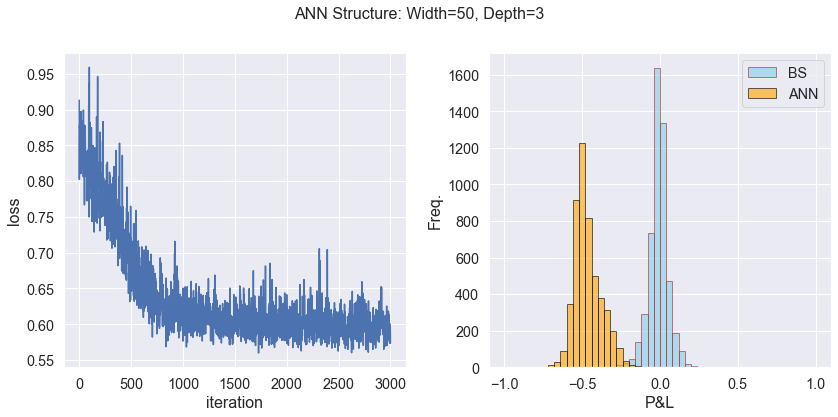

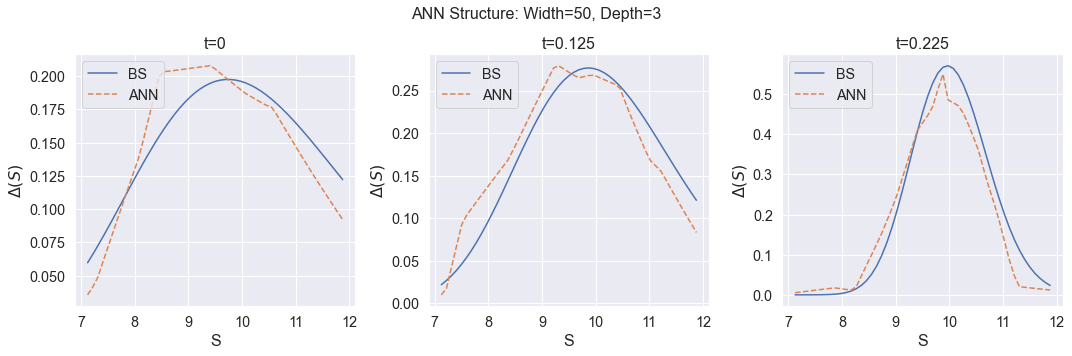

3500


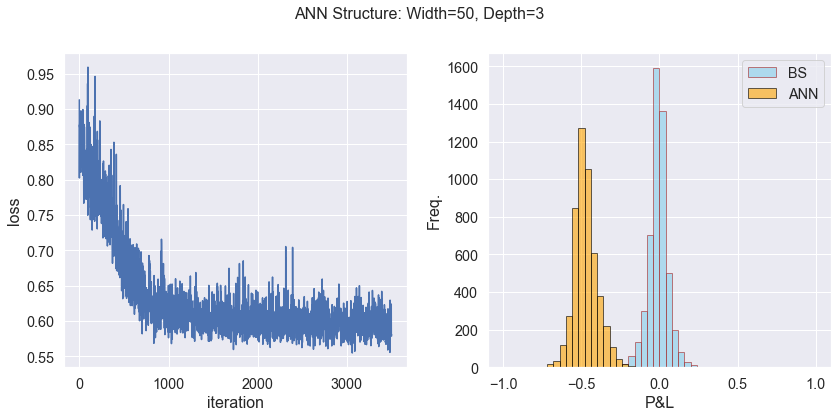

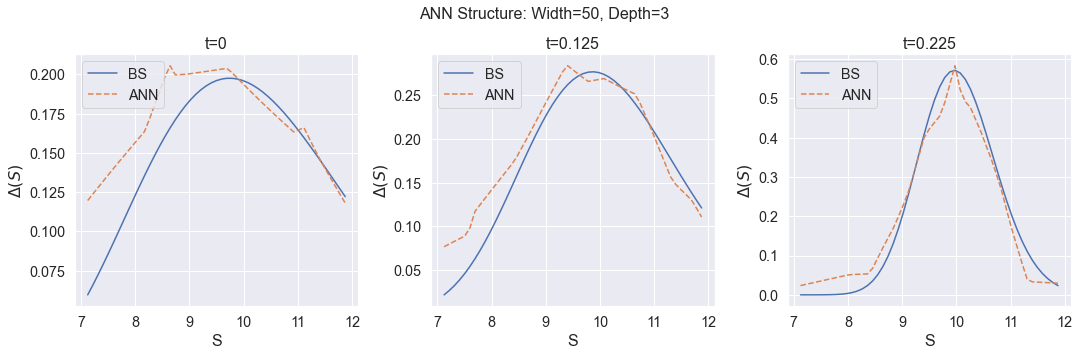

4000


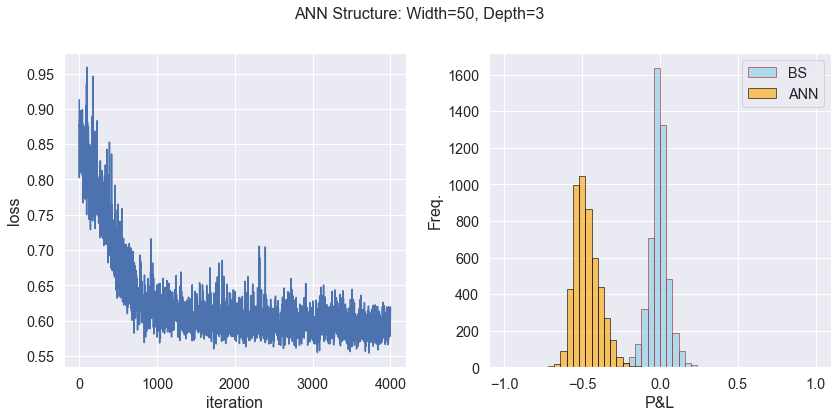

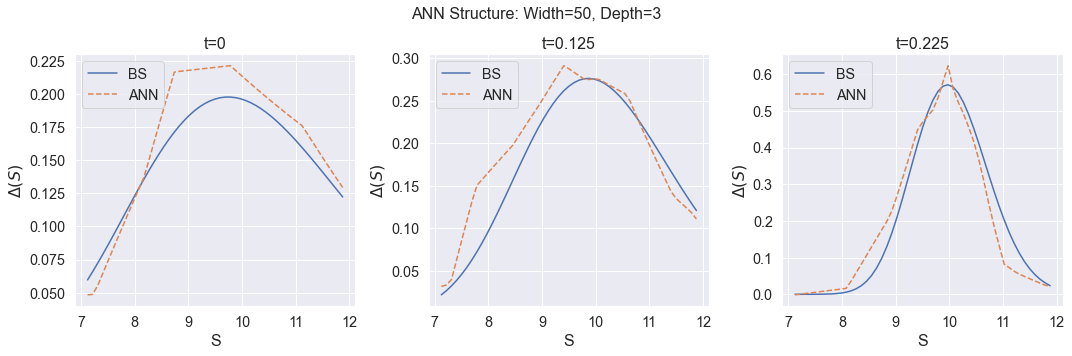

4500


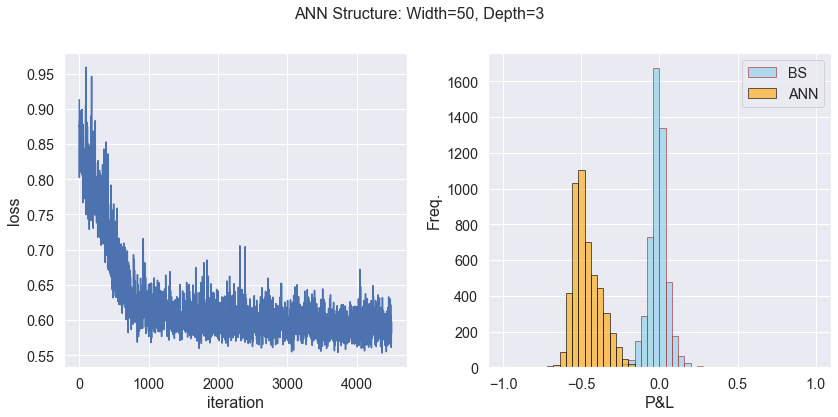

4999


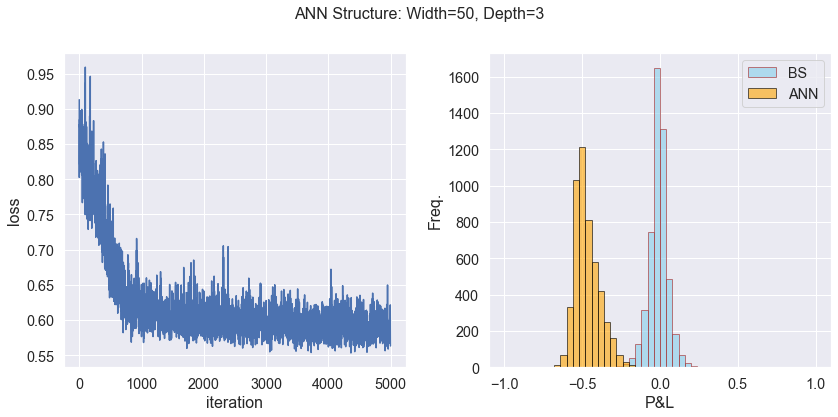

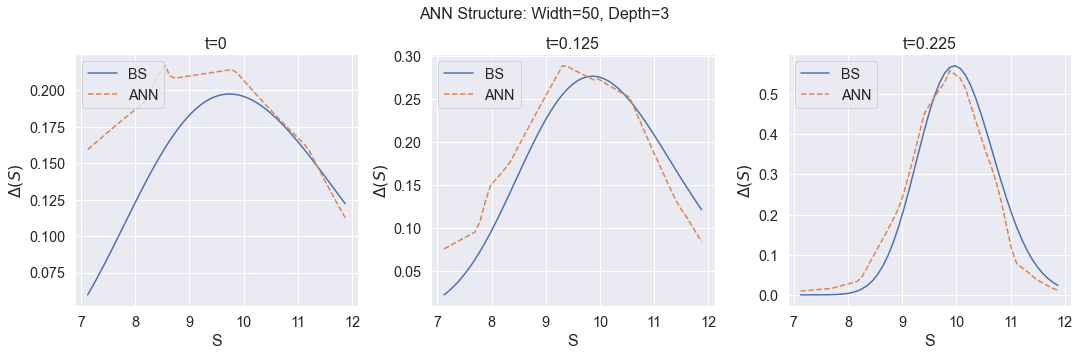

Finished Training


In [41]:
loss_hist = FitNet(net)

The Bull Spread Call Option Price that the trader needs to charge at the beginning while maintaining the criteria that the CVaR at 10% significance level cannot be less than $-0.02.

In [42]:
bull_spread = (-0.02+loss_hist[-1])*np.exp(-r*T)
bull_spread

0.5404983670036951

In [43]:
def RunHedge_compare_BS(S, alpha):
    '''
    S: a collection of simulations of asset prices
    each row is going to be one simulation
    each column is going to represent time
    
    alpha: the position that to hold in the risky asset
    '''
    
    # start the bank account with value of contract and purchasing initial shares
    # assume initially charge nothing for the option
    # the output of the neural net will have an extra dimension to it
    bank = bull_spread - alpha[:,0,0]*S[:,0] - abs(alpha[:,0,0])*0.005
    
    for i in range(NdT-1):
        
        # accumulate bank account to next time step
        bank *= np.exp(r*dt)
        
        # rebalance the position and consider the transaction cost $0.005 per asset traded
        bank -= (alpha[:,i+1,0]-alpha[:,i,0]) * S[:,i+1] + abs(alpha[:,i+1,0]-alpha[:,i,0])*0.005
        
    # liquidate terminal assets, and pay what you owe from the contract
    # owe the payoff of C1, so minus
    # long the payoff of C2, so plus
    bank += alpha[:,-1,0]*S[:,-1] + (S[:,-1]-K2)*(S[:,-1]>K2) - (S[:,-1]-K1)*(S[:,-1]>K1)  
    
    return bank

In [44]:
def Sim_compare_BS(net, nsims):
    
    # simulate the asset price
    S = torch.zeros((nsims, NdT))
    log_S = torch.zeros((nsims, NdT))
    S[:,0] = S0
    log_S[:,0] = np.log(S0)
    
    for i in range(NdT-1):
        log_S[:,i+1] = log_S[:,i]+(kappa*(theta - log_S[:,i]) - 0.5*sigma**2) * dt + sigma * sqrt_dt * torch.normal(0,1,size=(nsims,))
    
    S = torch.exp(log_S)
    #print("S",S)
    
    # combine the features into a tensor of dimension nsims x ndt x 2 
    x = torch.zeros((nsims, NdT,2))
    # first feature is time
    x[:,:,0] = torch.tensor(2*t/T-1).float().repeat(nsims,1)
    # second feature is asset price
    x[:,:,1] = 2*S/S0-1
    #print("x",x)
    
    # push the x values through the ANN -- the last dimension is treated as the features
    alpha = net(x)
    
    #print("alpha",alpha)
    
    bank = RunHedge_compare_BS(S, alpha)
    
    #print("bank",bank)

    return bank

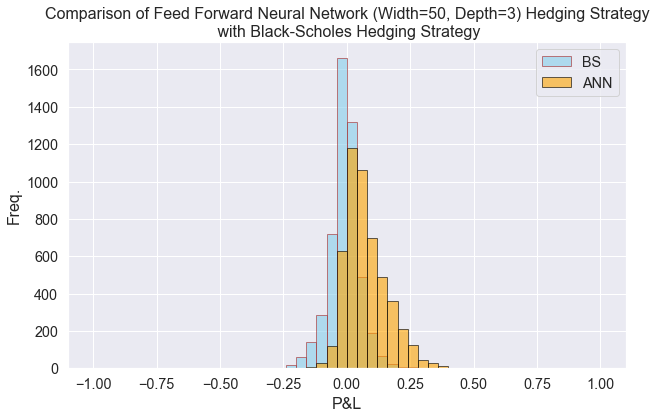

In [45]:
PnL_ANN = Sim_compare_BS(net, 5_000)
PnL_BS = Sim_BS(5_000)
plt.figure(figsize=(10,6))
plt.hist(PnL_BS.detach().numpy(), bins=np.linspace(-1,1,51), alpha=0.6,color="skyblue", ec="brown",label="BS");
plt.hist(PnL_ANN.detach().numpy(), bins=np.linspace(-1,1,51), alpha=0.6,color="orange",ec="black",label="ANN");   
plt.xlabel('P&L',fontsize=16);
plt.ylabel('Freq.',fontsize=16);
plt.title("Comparison of Feed Forward Neural Network (Width=50, Depth=3) Hedging Strategy\n with Black-Scholes Hedging Strategy",fontsize=16)
plt.legend();

# 5. Recurrent Neural Net Architecture

Then I use the recurrent neural networks to determine the optimal hedging strategies. Compared with simple feed forward neural network, RNN takes information from prior inputs to influrence the current input and output. In this project, I include the past asset price as the historical information to feed in the RNN. To overcome the hidden states constantly being written off problem, I use the Gated Recurrent Unit (GRU) RNN.

I use a slide window size of 2 to run a GRU RNN, that is the most recent 2 steps of asset prices as an input.

In [46]:
class rnnNet(nn.Module):
    
    def __init__(self, ni, hs, nl ):
        '''
        ni = number of input features
        hs = number of hidden states
        nl = potential layers specific to GRU
        '''
        
        #constructor
        super(rnnNet, self).__init__()
        
        # GRU layer
        self.GRU = nn.GRU(input_size=ni, hidden_size=hs, num_layers=nl)
        
        # GRU to output
        self.prop_h_to_out = nn.Linear(hs, 1)

    def forward(self, x):
        
        # input into  GRU layer (seq, batch, feature)
#         h_all, h_last = self.GRU(x)
        # sequence is time
        # batch: S0,S1,...S10
        _, h_last = self.GRU(x)
        
        # GRU output to output layer
        y = self.prop_h_to_out(h_last)
        
        return y

In [47]:
net_for_rnn = HedgeNet(50,3)

In [48]:
rnn_net = rnnNet(ni=2,hs=5,nl=4)

In [49]:
def RunHedge_rnn(S, alpha):
    '''
    S: a collection of simulations of asset prices
    each row is going to be one simulation
    each column is going to represent time
    
    alpha: the position that to hold in the risky asset
    '''
    
    # start the bank account with value of contract and purchasing initial shares
    # assume initially charge nothing for the option
    # the output of the neural net will have an extra dimension to it
    bank = - alpha[:,0,0]*S[:,0] - abs(alpha[:,0,0])*0.005
    
    for i in range(NdT-1):
        
        # accumulate bank account to next time step
        bank *= np.exp(r*dt)
        
        # rebalance the position and consider the transaction cost $0.005 per asset traded
        bank -= (alpha[:,i+1,0]-alpha[:,i,0]) * S[:,i+1] + abs(alpha[:,i+1,0]-alpha[:,i,0])*0.005
        
    # liquidate terminal assets, and pay what you owe from the contract
    # owe the payoff of C1, so minus
    # long the payoff of C2, so plus
    bank += alpha[:,-1,0]*S[:,-1] + (S[:,-1]-K2)*(S[:,-1]>K2) - (S[:,-1]-K1)*(S[:,-1]>K1)  
    
    return bank

In [50]:
def Sim_rnn(net,rnn,nsims):
    
    # simulate the asset price
    S = torch.zeros((nsims, NdT))
    log_S = torch.zeros((nsims, NdT))
    S[:,0] = S0
    log_S[:,0] = np.log(S0)
    
    for i in range(NdT-1):
        log_S[:,i+1] = log_S[:,i]+(kappa*(theta - log_S[:,i]) - 0.5*sigma**2) * dt + sigma * sqrt_dt * torch.normal(0,1,size=(nsims,))
    
    S = torch.exp(log_S)
    #print("S",S)
    # combine the features into a tensor of dimension nsims x ndt x 2 
    x = torch.zeros((nsims, NdT,2))
    # first feature is time
    x[:,:,0] = torch.tensor(2*t/T-1).float().repeat(nsims,1)
    # second feature is asset price
    x[:,:,1] = 2*S/S0-1
    
    # grab the past 2 asset prices and run GRU to obtain a final hidden state
    for j in range(2,S.shape[1]):
        S_batch = S[:,j-2:j].reshape((1,nsims,2))
        last_hidden_state = rnn(S_batch).mean(axis=0)
        last_hidden_state_feature = torch.squeeze(last_hidden_state,dim=1)
        x[:,j,1] = last_hidden_state_feature

    #print("x",x)
    
    # push the x values through the ANN -- the last dimension is treated as the features
    alpha = net(x)
    
    #print("alpha",alpha)
    
    bank = RunHedge_rnn(S, alpha)
    
    #print("bank",bank)

    return bank

In [51]:
def Plot_PnL_RNN(loss_hist, net, rnn):
    plt.figure(figsize=(10,5))
    plt.suptitle("GRU RNN - 4 layers and 5 hidden states",fontsize=16)
    plt.subplot(1,2,1)
    plt.plot(loss_hist)
    #plt.yscale('log')
    plt.xlabel('iteration',fontsize=16)
    plt.ylabel('loss',fontsize=16)
    #plt.ylim(1e-3,1)

    plt.subplot(1,2,2)
    PnL = Sim_rnn(net, rnn, 5_000)
    PnL_BS = Sim_BS(5_000)
    plt.hist(PnL_BS.detach().numpy(), bins=np.linspace(-1,1,51), color="skyblue", ec="brown",alpha=0.6, label="BS")
    plt.hist(PnL.detach().numpy(), bins=np.linspace(-1,1,51),color="orange",ec="black",alpha=0.6, label="RNN")    
    plt.xlabel('P&L',fontsize=16)
    plt.ylabel('Freq.',fontsize=16)
    #plt.ylim(0,1000)
    plt.legend()
    
    plt.tight_layout(pad=2)
    plt.show()

In [52]:
Plot_PnL_RNN([], net_for_rnn,rnn_net)

In [53]:
def FitNet_RNN(net,rnn):
    
    mini_batch_size = 100
    
    # create  optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.005)

    Nepochs = 5_000
    loss_hist = []
    
    Plot_PnL_RNN(loss_hist, net, rnn)
    
    for epoch in range(Nepochs):  # loop over the dataset multiple times

        # grab a mini-batch from simulations
        PnL = Sim_rnn(net, rnn, mini_batch_size)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # compute the loss associated with this output
        # CVaR_0.1 calculation
        q = torch.tensor([0.1])
        VaR_10 = np.quantile(PnL.detach().numpy(),q)
        CVaR_10 = PnL[PnL.detach().numpy()<=VaR_10].mean()
        loss = -CVaR_10

        # propogate the sensitivity of the output to the model parameters 
        # backwards through the computational graph
        loss.backward()

        # update the weights and biases by taking a SGD step
        optimizer.step()

        # store running loss
        loss_hist.append(  loss.item() )
        
        if( ( (epoch) % 500 == 0) and (epoch>10) ):
            print(epoch)
            Plot_PnL_RNN(loss_hist, net, rnn)
    
    print(epoch)
    Plot_PnL_RNN(loss_hist, net, rnn)

    print('Finished Training')

    return loss_hist

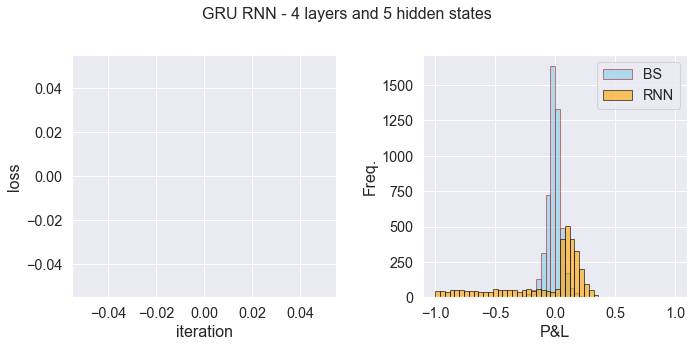

500


1000


1500


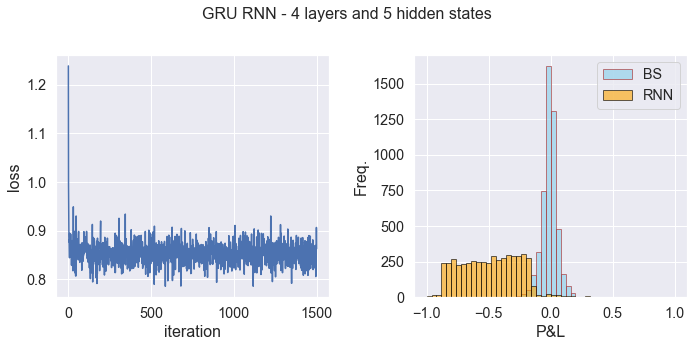

2000


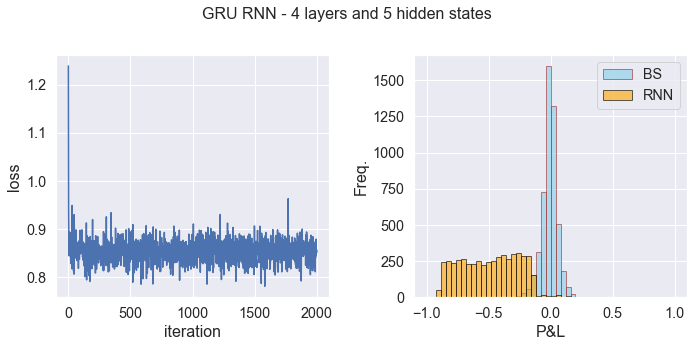

2500


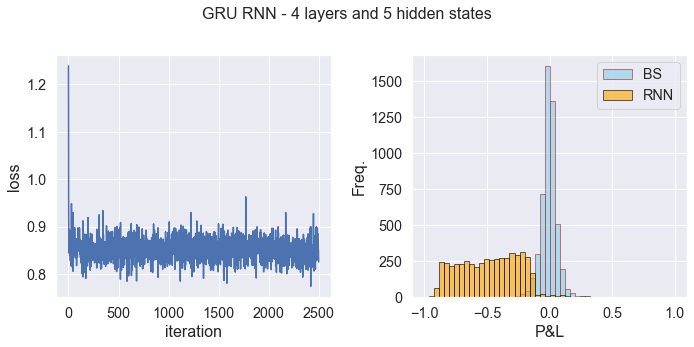

3000


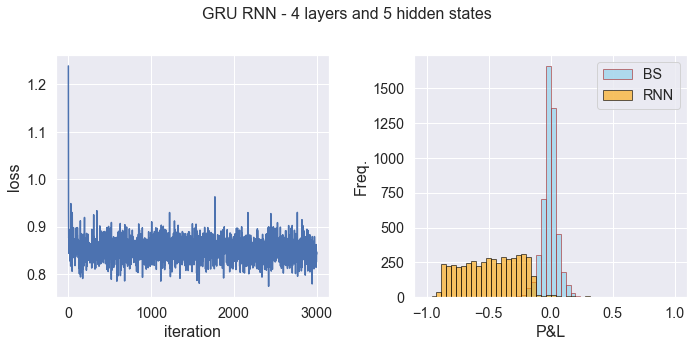

3500


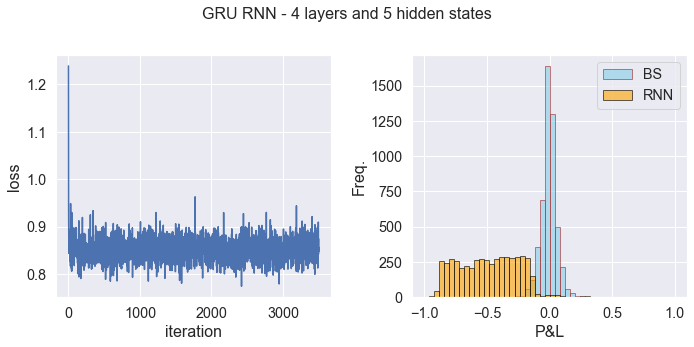

4000


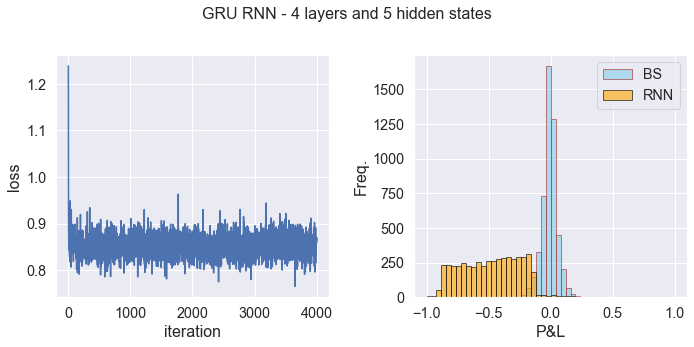

4500


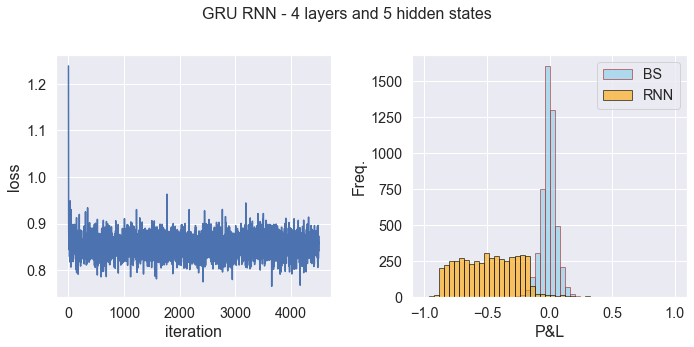

4999


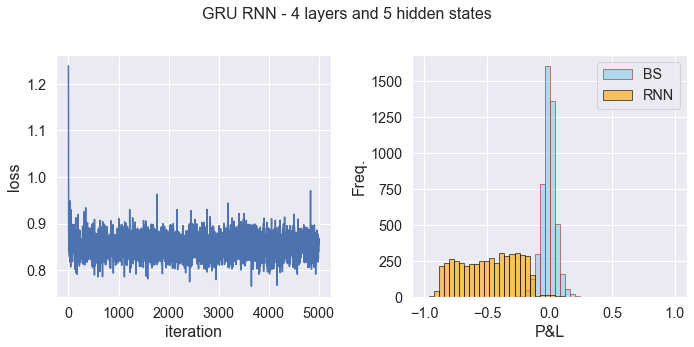

Finished Training


In [54]:
loss_hist_rnn = FitNet_RNN(net_for_rnn,rnn_net)

The Bull Spread Call Option Price that the trader needs to charge at the beginning while maintaining the criteria that the CVaR at 10% significance level cannot be less than $-0.02.

In [55]:
bull_spread = (-0.02+loss_hist_rnn[-1])*np.exp(-r*T)
bull_spread

0.8158974557592044

In [56]:
def RunHedge_rnn_compare_BS(S, alpha):
    '''
    S: a collection of simulations of asset prices
    each row is going to be one simulation
    each column is going to represent time
    
    alpha: the position that to hold in the risky asset
    '''
    
    # start the bank account with value of contract and purchasing initial shares
    # assume initially charge nothing for the option
    # the output of the neural net will have an extra dimension to it
    bank = bull_spread - alpha[:,0,0]*S[:,0] - abs(alpha[:,0,0])*0.005
    
    for i in range(NdT-1):
        
        # accumulate bank account to next time step
        bank *= np.exp(r*dt)
        
        # rebalance the position and consider the transaction cost $0.005 per asset traded
        bank -= (alpha[:,i+1,0]-alpha[:,i,0]) * S[:,i+1] + abs(alpha[:,i+1,0]-alpha[:,i,0])*0.005
        
    # liquidate terminal assets, and pay what you owe from the contract
    # owe the payoff of C1, so minus
    # long the payoff of C2, so plus
    bank += alpha[:,-1,0]*S[:,-1] + (S[:,-1]-K2)*(S[:,-1]>K2) - (S[:,-1]-K1)*(S[:,-1]>K1)  
    
    return bank

In [57]:
def Sim_rnn_compare_BS(net,rnn,nsims):
    
    # simulate the asset price
    S = torch.zeros((nsims, NdT))
    log_S = torch.zeros((nsims, NdT))
    S[:,0] = S0
    log_S[:,0] = np.log(S0)
    
    for i in range(NdT-1):
        log_S[:,i+1] = log_S[:,i]+(kappa*(theta - log_S[:,i]) - 0.5*sigma**2) * dt + sigma * sqrt_dt * torch.normal(0,1,size=(nsims,))
    
    S = torch.exp(log_S)
    #print("S",S)
    # combine the features into a tensor of dimension nsims x ndt x 2 
    x = torch.zeros((nsims, NdT,2))
    # first feature is time
    x[:,:,0] = torch.tensor(2*t/T-1).float().repeat(nsims,1)
    # second feature is asset price
    x[:,:,1] = 2*S/S0-1
    
    # grab the past 5 asset prices and run GRU to obtain a final hidden state
    for j in range(2,S.shape[1]):
        S_batch = S[:,j-2:j].reshape((1,nsims,2))
        last_hidden_state = rnn(S_batch).mean(axis=0)
        last_hidden_state_feature = torch.squeeze(last_hidden_state,dim=1)
        x[:,j,1] = last_hidden_state_feature

    #print("x",x)
    
    # push the x values through the ANN -- the last dimension is treated as the features
    alpha = net(x)
    
    #print("alpha",alpha)
    
    bank = RunHedge_rnn_compare_BS(S, alpha)
    
    #print("bank",bank)

    return bank

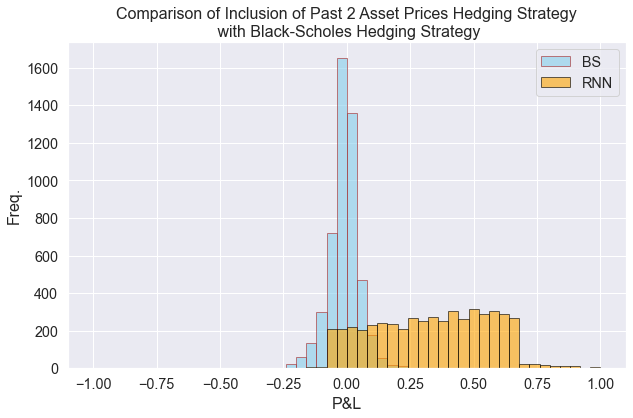

In [58]:
PnL_RNN = Sim_rnn_compare_BS(net_for_rnn, rnn_net, 5_000)
PnL_BS = Sim_BS(5_000)
plt.figure(figsize=(10,6))
plt.hist(PnL_BS.detach().numpy(), bins=np.linspace(-1,1,51), alpha=0.6,color="skyblue", ec="brown",label="BS");
plt.hist(PnL_RNN.detach().numpy(), bins=np.linspace(-1,1,51), alpha=0.6,color="orange",ec="black",label="RNN");   
plt.xlabel('P&L',fontsize=16);
plt.ylabel('Freq.',fontsize=16);
plt.title("Comparison of Inclusion of Past 2 Asset Prices Hedging Strategy\n with Black-Scholes Hedging Strategy",fontsize=16)
plt.legend();